In [1]:
import json

import numpy as np
from matplotlib import pyplot as plt

from PIL import Image

In [2]:
with open('stats.json', 'r') as f:
    stats = json.load(f)

n_rows = stats['rows']
colors = stats['colors']
start_date = stats['start_time']
color_ids = {c: np.uint32(i) for i, c in enumerate(colors)}
first_expansion = stats['first_expansion_index']
second_expansion = stats['second_expansion_index']
last_nonwhite = stats['last_nonwhite_index']

all_rows = np.zeros((n_rows, 6), dtype=np.uint32)

In [3]:
def hex_to_rgb(c):
    return np.array([int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)], dtype=np.uint8)

def ids_to_pic(ids):
    id_to_np = np.array([hex_to_rgb(c) for c in colors], dtype=np.uint8)
    pic = np.zeros(ids.shape + (3,), dtype=np.uint8)
    for y in range(ids.shape[0]):
        for x in range(ids.shape[1]):
            pic[y, x] = id_to_np[ids[y, x]]
    return pic

def draw_pic(pic):
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(pic)
    plt.show()

In [4]:
all_rows = np.load('data/sorted_pixels.npy')
checkpoints = np.load('data/checkpoints.npy')

In [ ]:
# create checkpoints of what the grid looked like at every 1e6 pixels placed

place_grid = np.zeros((2000, 2000), dtype=np.int8)
checkpoints = np.zeros((len(all_rows) // 1000000 + 1, 2000, 2000), dtype=np.int8)


for i, row in enumerate(all_rows):
    s = np.s_[row[3], row[2]]
    if row[4] != 0:
        s = np.s_[row[3]:row[5]+1, row[2]:row[4]+1]
    place_grid[s] = row[1]

    if i % 1e6 == 0:
        print(i)
        checkpoints[i // 1000000] = place_grid.copy()
print(i)
np.save('data/checkpoints.npy', checkpoints)

In [ ]:
# gets the details of each censored area

place_grid = checkpoints[i // 1000000].copy()

censored_images = []
censored_details = []

for row in all_rows:
    s = np.s_[row[3], row[2]]
    if row[4] != 0:
        s = np.s_[row[3]:row[5]+1, row[2]:row[4]+1]
        censored_images += [place_grid[s].copy()]
        censored_details += [f'{row[0] // (1000 * 60 * 60)}:{(row[0] // (1000 * 60)) % 60:02}, x={row[2]}, y={row[3]}']

        draw_pic(ids_to_pic(censored_images[-1]))
        print(censored_details[-1])

        im = Image.fromarray(ids_to_pic(censored_images[-1]))
        im.save(f'out/censored_{len(censored_images)}.png', mode='RGB')
    place_grid[s] = row[1]

In [21]:
for line in censored_details:
    print(line)

1:59, x=862, y=540
2:02, x=862, y=540
2:02, x=871, y=546
58:19, x=298, y=1770
58:20, x=298, y=1805
58:24, x=257, y=1736
58:26, x=251, y=1805
58:28, x=271, y=1835
58:45, x=297, y=1750
60:38, x=1349, y=1718
63:28, x=23, y=1523
63:32, x=44, y=1652
63:45, x=51, y=1691
75:14, x=551, y=1311
75:15, x=547, y=1330
78:45, x=1373, y=1400
78:45, x=1371, y=1438
78:45, x=1372, y=1472
78:45, x=1375, y=1355


In [26]:
# gets the row index of the last non-white pixel

last_nonwhite = 0
for i in range(len(all_rows) - 1, 0, -1):
    if all_rows[i, 1] != 0:
        last_nonwhite = i
        break
print(last_nonwhite)

155926003


In [28]:
# gets the row indexes where the first and second expansion occur

first_expansion = 0
second_expansion = 0
for i in range(len(all_rows)):
    if first_expansion == 0 and all_rows[i, 2] > 999:
        first_expansion = i
    if all_rows[i, 3] > 999:
        second_expansion = i
        break
print(first_expansion)
print(all_rows[first_expansion])
print(second_expansion)
print(all_rows[second_expansion])

28190224
[99645924       31     1007      491        0        0]
71772961
[195583040        15      1338      1267         0         0]


In [5]:
# get cumulative weighted colors


def update_grid(grid, row):
    s = np.s_[row[3], row[2]]
    if row[4] != 0:
        s = np.s_[row[3]:row[5]+1, row[2]:row[4]+1]
    grid[s] = row[1]

start_time = all_rows[second_expansion, 0]
end_time = all_rows[last_nonwhite, 0]

check_first_i = int(second_expansion // 1000000)
place_grid = checkpoints[check_first_i].copy()

for row in all_rows[check_first_i * 1000000:second_expansion]:
    update_grid(place_grid, row)

c_w_color_grid = np.zeros((2000, 2000, len(colors)), dtype=np.float32) # cumulative weighted color grid
last_changed = np.full((2000, 2000), start_time, dtype=np.uint32)

for row in all_rows[second_expansion:last_nonwhite+1]:
    def upd(x, y): # update
        weight = ((row[0] - start_time) / (end_time - start_time)) ** 2
        weight -= ((last_changed[y, x] - start_time) / (end_time - start_time)) ** 2
        c_w_color_grid[y, x, place_grid[y, x]] += weight

    if row[4] == 0:
        s = np.s_[row[3], row[2]]
        upd(row[2], row[3])
    else:
        s = np.s_[row[3]:row[5]+1, row[2]:row[4]+1]
        for y in range(row[3], row[5]+1):
            for x in range(row[2], row[4]+1):
                upd(x, y)
    last_changed[s] = row[0]
    place_grid[s] = row[1]

for y in range(2000):
    for x in range(2000):
        weight = 1
        weight -= ((last_changed[y, x] - start_time) / (end_time - start_time)) ** 2
        c_w_color_grid[y, x, place_grid[y, x]] += weight


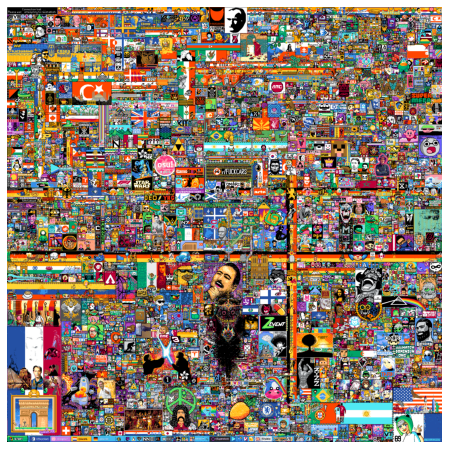

In [8]:
pic = ids_to_pic(np.argmax(c_w_color_grid, axis=-1))
draw_pic(pic)
Image.fromarray(pic).save(f'out/final_cumulative_weighted.png', mode='RGB')

(2000, 2000, 32, 3)
(2000, 2000, 32)


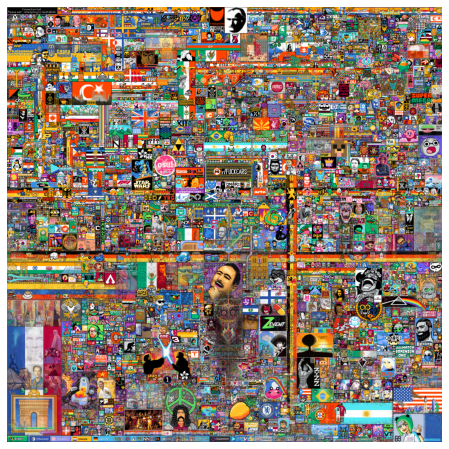

In [19]:
np_rgbs = np.array([[[hex_to_rgb(hex) for hex in colors]]])
all_colors_grid = np.repeat(np_rgbs, 2000, 1)
all_colors_grid = np.repeat(all_colors_grid, 2000, 0)

print(all_colors_grid.shape)
print(c_w_color_grid.shape)

pic = np.minimum(np.sum(all_colors_grid * c_w_color_grid[..., np.newaxis], axis=2), 255).astype(np.uint8)
draw_pic(pic)
Image.fromarray(pic).save(f'out/final_cumulative_weighted_weighted_mean.png', mode='RGB')

In [20]:
print(all_rows[second_expansion])
print(all_rows[last_nonwhite])

[195583040        15      1338      1267         0         0]
[295409869        17      1871       948         0         0]
